# Experimentar con Nigeria de validación


# Importaciones

In [1]:
%%capture
!%pip install mne
!%pip install --upgrade mne
!%pip install -U mne

In [2]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mne
import seaborn as sns
from mne import time_frequency
from sklearn.metrics import accuracy_score, recall_score
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# Descomprimir, Leer, Convetir a MNE y Categorizar los datos

#unzip the files
data = ZipFile('EEGs_Guinea-Bissau.zip')
data2 = ZipFile('EEGs_Nigeria.zip')
data.extractall()
data2.extractall()

In [3]:
meta_df=pd.read_csv('https://zenodo.org/record/1252141/files/metadata_guineabissau.csv')
meta_df2 = pd.read_csv('https://zenodo.org/record/1252141/files/metadata_nigeria.csv')
meta_df.head()

,subject.id,Group,Eyes.condition,Remarks,recordedPeriod,startTime
0,1,Epilepsy,closed-3min-then-open-2min,by 45s reposition electrodes,301,27/5/2020 14:33
1,2,Control,open-3min-then-closed-2min,NaN,309,26/5/2020 22:44
2,3,Epilepsy,closed-3min-then-open-2min,NaN,309,27/5/2020 14:26
3,4,Epilepsy,closed-3min-then-open-2min,"Green lights not shown, but good EEG traces",299,27/5/2020 15:23
4,5,Control,closed-3min-then-open-2min,NaN,302,23/5/2020 19:09


In [4]:
#now i need to seprate Epilepsy vs Control subjects
EP_sub=meta_df['subject.id'][meta_df['Group']=='Epilepsy']
CT_sub=meta_df['subject.id'][meta_df['Group']=='Control']

In [5]:
#now i need to seprate Epilepsy vs Control subjects
EP_sub2=meta_df2['subject.id'][meta_df2['Group']=='Epilepsy']
CT_sub2=meta_df2['subject.id'][meta_df2['Group']=='Control']

In [6]:
#read csv files
Epilepsy2=[pd.read_csv('EEGs_Nigeria/signal-{}.csv.gz'.format(i), compression='gzip') for i in  EP_sub2]
Control2=[pd.read_csv('EEGs_Nigeria/signal-{}.csv.gz'.format(i), compression='gzip') for i in  CT_sub2]

In [7]:
#read csv files
Epilepsy=[pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip') for i in  EP_sub]
Control=[pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip') for i in  CT_sub]

In [8]:
Epilepsy[0].head()

,Unnamed: 0,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,...,CQ_F3,CQ_P7,CQ_P8,CQ_F4,CQ_AF3,CQ_FC5,CQ_O1,CQ_T8,CQ_F8,CQ_DRL
0,1,4426.153846,3994.871795,4408.205128,3847.692308,4690.256410,3895.897436,4702.051282,3914.871795,4049.743590,...,4,4,4,4,4,4,4,4,4,4
1,2,4420.512821,3986.666667,4394.358974,3836.923077,4678.461538,3886.666667,4696.410256,3910.769231,4054.358974,...,4,4,4,4,4,4,4,4,4,4
2,3,4413.846154,3986.153846,4386.666667,3831.794872,4654.871795,3881.025641,4690.769231,3908.205128,4066.666667,...,4,4,4,4,4,4,4,4,4,4
3,4,4407.692308,3984.615385,4384.102564,3832.820513,4644.615385,3883.076923,4686.153846,3910.256410,4063.076923,...,4,4,4,4,4,4,4,4,4,4
4,5,4407.179487,3978.974359,4382.564103,3832.307692,4647.692308,3878.974359,4685.641026,3903.076923,4057.948718,...,4,4,4,4,4,4,4,4,4,4


In [9]:
#remove non eeg channels
Epilepsy=[i.iloc[:,1:15] for i in  Epilepsy]
Control=[i.iloc[:,1:15] for i in  Control]

In [10]:
#remove non eeg channels
Epilepsy2=[i.iloc[:,1:15] for i in  Epilepsy]
Control2=[i.iloc[:,1:15] for i in  Control]

In [11]:
Epilepsy[0].head()

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8
0,4426.153846,3994.871795,4408.205128,3847.692308,4690.256410,3895.897436,4702.051282,3914.871795,4049.743590,4297.948718,4186.153846,4132.820513,4106.666667,4076.410256
1,4420.512821,3986.666667,4394.358974,3836.923077,4678.461538,3886.666667,4696.410256,3910.769231,4054.358974,4295.897436,4187.179487,4126.666667,4105.641026,4065.128205
2,4413.846154,3986.153846,4386.666667,3831.794872,4654.871795,3881.025641,4690.769231,3908.205128,4066.666667,4301.025641,4188.205128,4123.076923,4103.076923,4063.589744
3,4407.692308,3984.615385,4384.102564,3832.820513,4644.615385,3883.076923,4686.153846,3910.256410,4063.076923,4298.974359,4184.615385,4127.179487,4095.384615,4071.282051
4,4407.179487,3978.974359,4382.564103,3832.307692,4647.692308,3878.974359,4685.641026,3903.076923,4057.948718,4295.384615,4182.564103,4128.205128,4090.769231,4064.102564


In [12]:
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    data.filter(l_freq=0.1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(data,duration=5,overlap=1)
    epochs=epochs.drop_bad()

    return epochs

In [13]:
%%capture
#Convert each dataframe to mne object
Epilepsy=[convertDF2MNE(i) for i in  Epilepsy]
Control=[convertDF2MNE(i) for i in  Control]

#concatenate the epochs
Epilepsy_epochs=mne.concatenate_epochs(Epilepsy)
Control_epochs=mne.concatenate_epochs(Control)

In [14]:
%%capture
#Convert each dataframe to mne object
Epilepsy2=[convertDF2MNE(i) for i in  Epilepsy2]
Control2=[convertDF2MNE(i) for i in  Control2]

#concatenate the epochs
Epilepsy_epochs2=mne.concatenate_epochs(Epilepsy2)
Control_epochs2=mne.concatenate_epochs(Control2)

In [15]:
Epilepsy_group=np.concatenate([[i]*len(Epilepsy[i]) for i in range(len(Epilepsy))])#create a list of list where each sub list corresponds to subject_no
Control_group=np.concatenate([[i]*len(Control[i]) for i in range(len(Control))])#create a list of list where each sub list corresponds to subject_no

Epilepsy_label=np.concatenate([[0]*len(Epilepsy[i]) for i in range(len(Epilepsy))])
Control_label=np.concatenate([[1]*len(Control[i]) for i in range(len(Control))])

In [16]:
Epilepsy_group2=np.concatenate([[i]*len(Epilepsy2[i]) for i in range(len(Epilepsy2))])#create a list of list where each sub list corresponds to subject_no
Control_group2=np.concatenate([[i]*len(Control2[i]) for i in range(len(Control2))])#create a list of list where each sub list corresponds to subject_no

Epilepsy_label2=np.concatenate([[0]*len(Epilepsy2[i]) for i in range(len(Epilepsy2))])
Control_label2=np.concatenate([[1]*len(Control2[i]) for i in range(len(Control2))])

In [17]:
#combine data
data=mne.concatenate_epochs([Epilepsy_epochs,Control_epochs])
group=np.concatenate((Epilepsy_group,Control_group))
label=np.concatenate((Epilepsy_label,Control_label))
print(len(data),len(group),len(label))

Not setting metadata
7456 matching events found
No baseline correction applied
7456 7456 7456


In [18]:
#combine data
data2=mne.concatenate_epochs([Epilepsy_epochs2,Control_epochs2])
group2=np.concatenate((Epilepsy_group2,Control_group2))
label2=np.concatenate((Epilepsy_label2,Control_label2))
print(len(data2),len(group2),len(label2))

Not setting metadata
7456 matching events found
No baseline correction applied
7456 7456 7456


# EDA

In [19]:
n_epochs = len(data2)
n_channels = data2.info['nchan']
n_time_points = data2.get_data(copy=False).shape[2]

# Calculate and display summary statistics for EEG data
eeg_data2 = data2.get_data(copy=False)  # Get the EEG data
mean_data2 = np.mean(eeg_data2, axis=(0, 2))  # Calculate the mean across epochs and time points
std_data2 = np.std(eeg_data2, axis=(0, 2))    # Calculate the standard deviation

In [21]:
print("Number of Epochs:", n_epochs)
print("Number of Channels:", n_channels)
print("Number of Time Points:", n_time_points)
print("Mean EEG Data:", mean_data2)
print("Standard Deviation of EEG Data:", std_data2)

Number of Epochs: 7456
Number of Channels: 13
Number of Time Points: 640
Mean EEG Data: [-1.13478061  0.54753286 -0.75147842  0.48098015 -0.95961523  0.00603352
 -1.55172522  1.68918632 -0.71525397  1.48227812 -0.47941233  1.72127775
 -0.33502296]
Standard Deviation of EEG Data: [195.21375011 219.40840654 185.93681716 199.70255234 208.52507164
 182.23858077 184.21029761 216.43698378 190.28393501 187.16842921
 212.10912754 201.12979076 193.08145783]


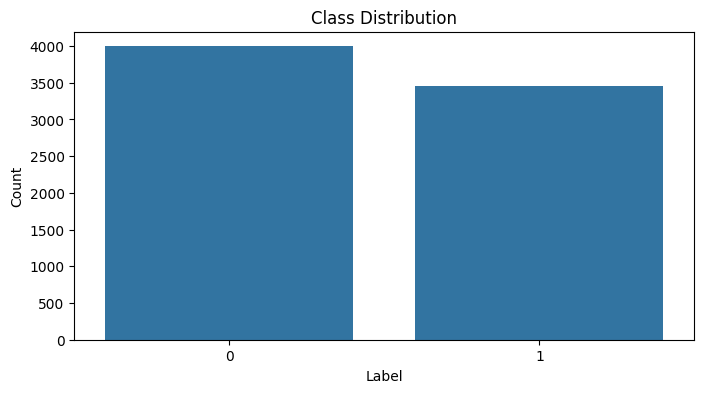

In [22]:
plt.figure(figsize=(8, 4))
sns.countplot(x=label2)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# Extraer características de potencia del espectro de señales

In [65]:
def eeg_power_band(epochs):
    # Define las bandas de frecuencia específicas
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30],
                  "gamma": [30, 64]}

    # Compute la PSD usando el método de Welch
    psds, freqs = mne.time_frequency.psd_array_welch(epochs.get_data(copy=False), sfreq=epochs.info['sfreq'], fmin=0.5, fmax=64, n_fft=256, window='hamming')

    # Normaliza las PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    # Para cada banda de frecuencia, calcula la media de la PSD en esa banda
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band)

    return np.concatenate(X, axis=1)


In [ ]:
features=[]
for d in range(len(data)):#get features from each epoch and save in a list
    print(d)
    features.append(eeg_power_band(data[d]))

In [25]:
features=np.concatenate(features)

In [66]:
features2=[]
for d in range(len(data2)):#get features from each epoch and save in a list
    print(d)
    features2.append(eeg_power_band(data2[d]))

0
Effective window size : 2.000 (s)
1
Effective window size : 2.000 (s)
2
Effective window size : 2.000 (s)
3
Effective window size : 2.000 (s)
4
Effective window size : 2.000 (s)
5
Effective window size : 2.000 (s)
6
Effective window size : 2.000 (s)
7
Effective window size : 2.000 (s)
8
Effective window size : 2.000 (s)
9
Effective window size : 2.000 (s)
10
Effective window size : 2.000 (s)
11
Effective window size : 2.000 (s)
12
Effective window size : 2.000 (s)
13
Effective window size : 2.000 (s)
14
Effective window size : 2.000 (s)
15
Effective window size : 2.000 (s)
16
Effective window size : 2.000 (s)
17
Effective window size : 2.000 (s)
18
Effective window size : 2.000 (s)
19
Effective window size : 2.000 (s)
20
Effective window size : 2.000 (s)
21
Effective window size : 2.000 (s)
22
Effective window size : 2.000 (s)
23
Effective window size : 2.000 (s)
24
Effective window size : 2.000 (s)
25
Effective window size : 2.000 (s)
26
Effective window size : 2.000 (s)
27
Effectiv

In [67]:
features2=np.concatenate(features2)

# Pruebas

## Modelo 1

In [68]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features2)
labels_encoded = to_categorical(label2)

In [69]:
# Cargar el modelo
model1 = load_model('models/modelo_inicial_g.h5')

In [70]:
print(features_scaled_.shape)


(7456, 70)


In [81]:
# Agregar 5 columnas de ceros
features_scaled_ = np.hstack((features_scaled, np.zeros((features_scaled.shape[0], 6))))


In [82]:
print(features_scaled_.shape)
print(labels_encoded.shape)


(7456, 84)
(7456, 2)


In [73]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

In [84]:
# Evaluar el modelo en el conjunto de prueba
_, recall, accuracy = model1.evaluate(features_scaled_, labels_encoded, verbose=0)
print('Accuracy: ', accuracy)
print('Recall: ', recall)

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

## Modelo 2

In [85]:
X_2 = features_scaled_.reshape((features_scaled_.shape[0], 1, features_scaled_.shape[1]))

In [86]:
# Cargar el modelo
model2 = load_model('models/modelo_RNN_g.h5')

In [87]:
# Evaluación
_, accuracy = model2.evaluate(X_2, labels_encoded, verbose=0)
print('Accuracy: ', accuracy)

Accuracy:  0.5505632758140564


In [88]:
# Calcular recall
y_pred = model2.predict(X_2)
y_pred_classes = np.argmax(y_pred, axis=1)
recall = recall_score(np.argmax(labels_encoded, axis=1), y_pred_classes)  # Asegurar que y_test está codificado correctamente
print('Recall: ', recall)

233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Recall:  0.4455359722623519


# Ventanas Temporales

In [89]:
def create_sliding_window(features, labels, window_size, step_size):
    segments = []
    window_labels = []

    # Asegurarse de que las etiquetas son de la misma longitud que las características
    if len(features) != len(labels):
        raise ValueError("La longitud de las características y las etiquetas debe coincidir")

    # Crear segmentos usando la ventana deslizante
    for start_pos in range(0, len(features) - window_size + 1, step_size):
        end_pos = start_pos + window_size
        segment = features[start_pos:end_pos]
        segments.append(segment)

        # Aquí suponemos que el label de cada ventana es el label del último punto de datos en la ventana
        window_labels.append(labels[end_pos - 1])

    return np.array(segments), np.array(window_labels)

In [90]:
window_size = 256  # 2 segundos con 128 Hz de frecuencia de muestreo
step_size = 128    # 1 segundo con 128 Hz de frecuencia de muestreo

# Aplicar ventana deslizante
X, y = create_sliding_window(features_scaled_, labels_encoded, window_size, step_size)

In [91]:
y_encoded = to_categorical(y, num_classes=2)

In [92]:
# Cargar el modelo
model3 = load_model('models/modelo_ventanas_g.h5')

In [94]:
# Evaluar el modelo
_, accuracy, recall = model3.evaluate(X, y_encoded, verbose=0)
print("Accuracy:", accuracy)
print("Recall:", recall)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_35" is incompatible with the layer: expected axis -1 of input shape to have value 80640, but received input with shape (None, 21504)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 256, 84), dtype=float32)
  • training=False
  • mask=None